[[0.75 0.65 0.18 0.15 0.11]
 [0.96 0.82 0.69 0.64 0.67]
 [0.58 0.85 0.15 0.57 0.37]
 [0.67 0.9  0.27 0.91 0.29]
 [0.69 0.42 0.36 0.29 0.38]]


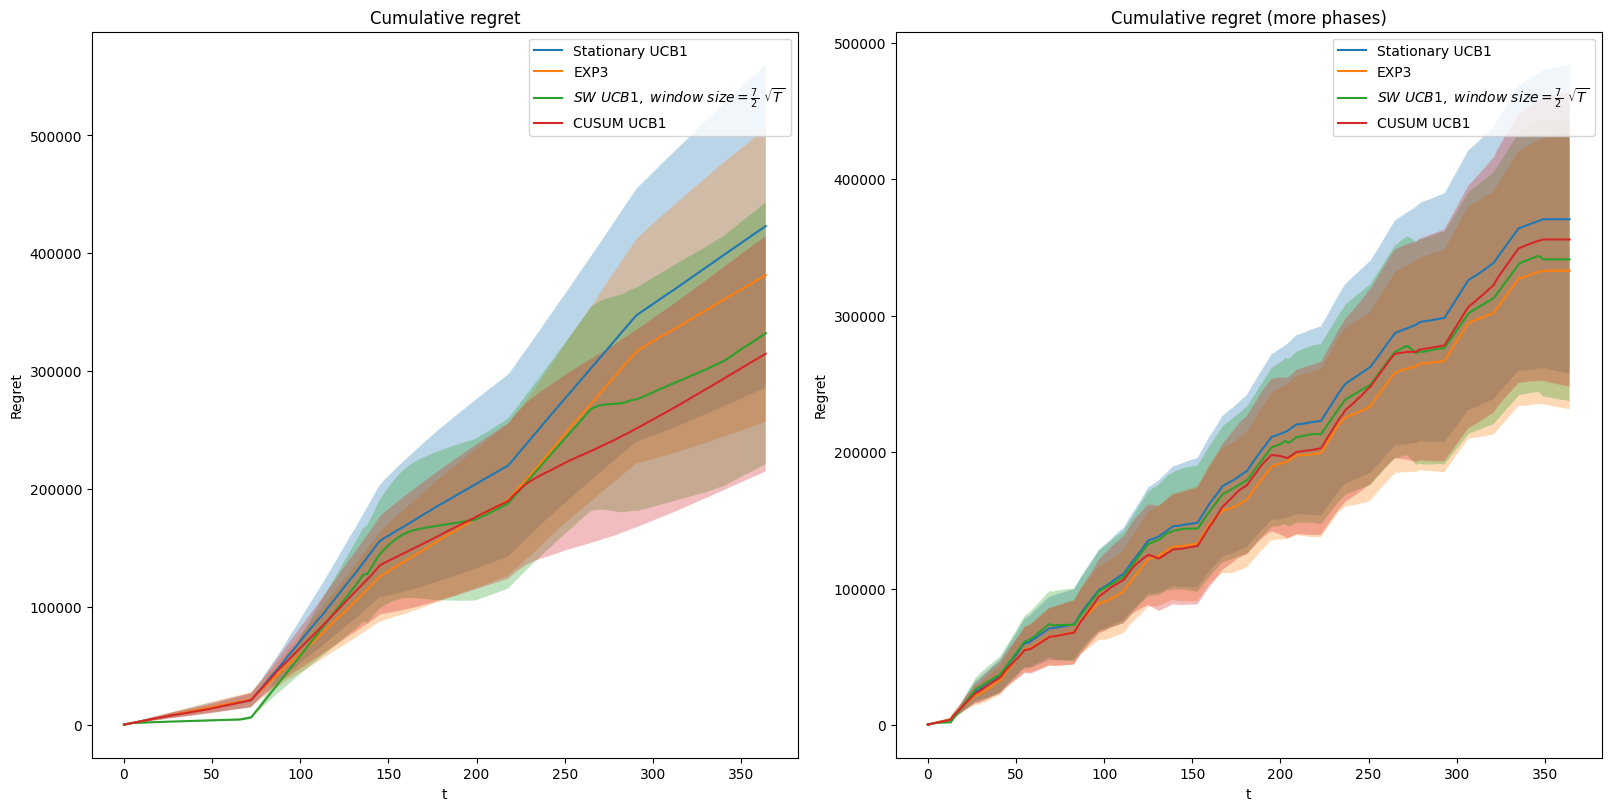

[[0.88 0.84 0.46 0.27 0.13]
 [0.91 0.67 0.58 0.32 0.11]
 [0.86 0.69 0.26 0.42 0.87]
 [0.13 0.94 0.74 0.98 0.54]
 [0.97 0.53 0.57 0.24 0.46]]


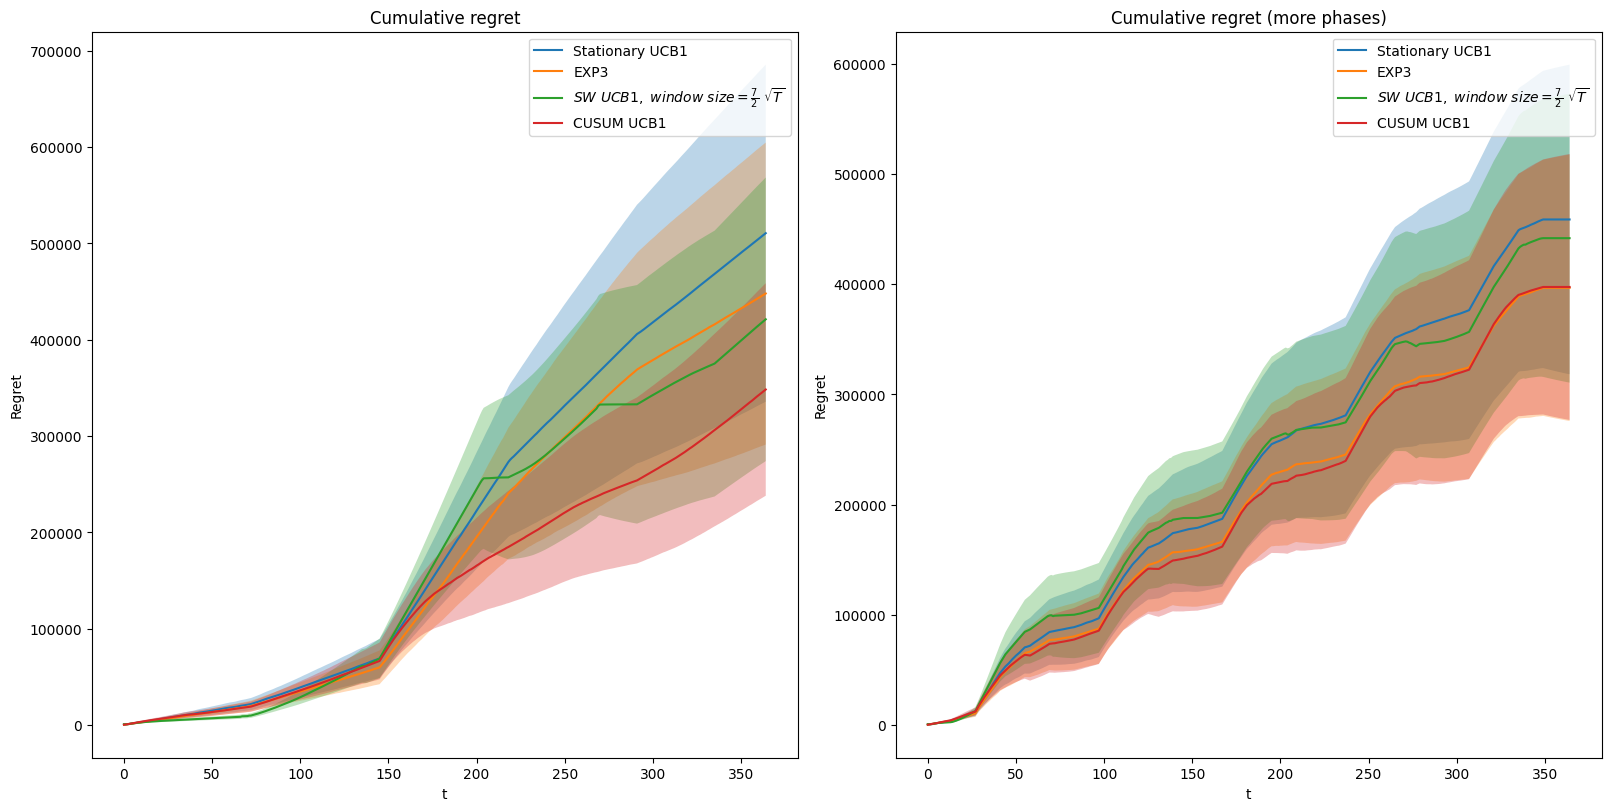

[[0.88 0.55 0.33 0.15 0.12]
 [0.99 0.27 0.71 0.22 0.42]
 [0.32 0.62 0.64 0.19 0.64]
 [0.19 0.44 0.81 0.45 0.44]
 [0.86 0.33 0.32 0.11 0.53]]


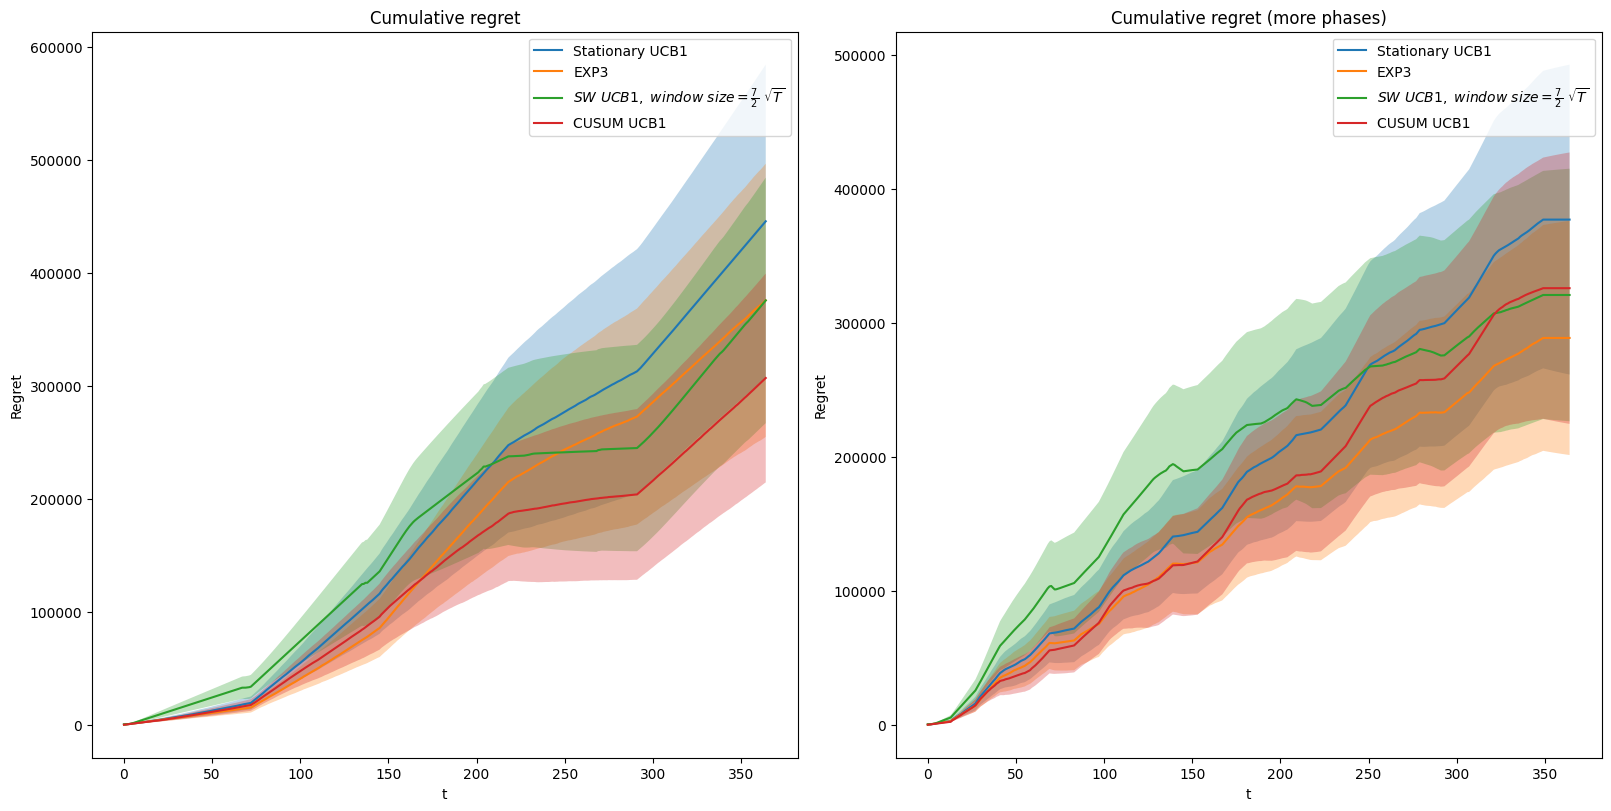

[[0.87 0.73 0.38 0.25 0.23]
 [0.99 0.49 0.23 0.28 0.2 ]
 [0.89 0.23 0.9  0.72 0.55]
 [0.92 0.72 0.28 0.73 0.83]
 [0.54 0.96 0.17 0.19 0.65]]


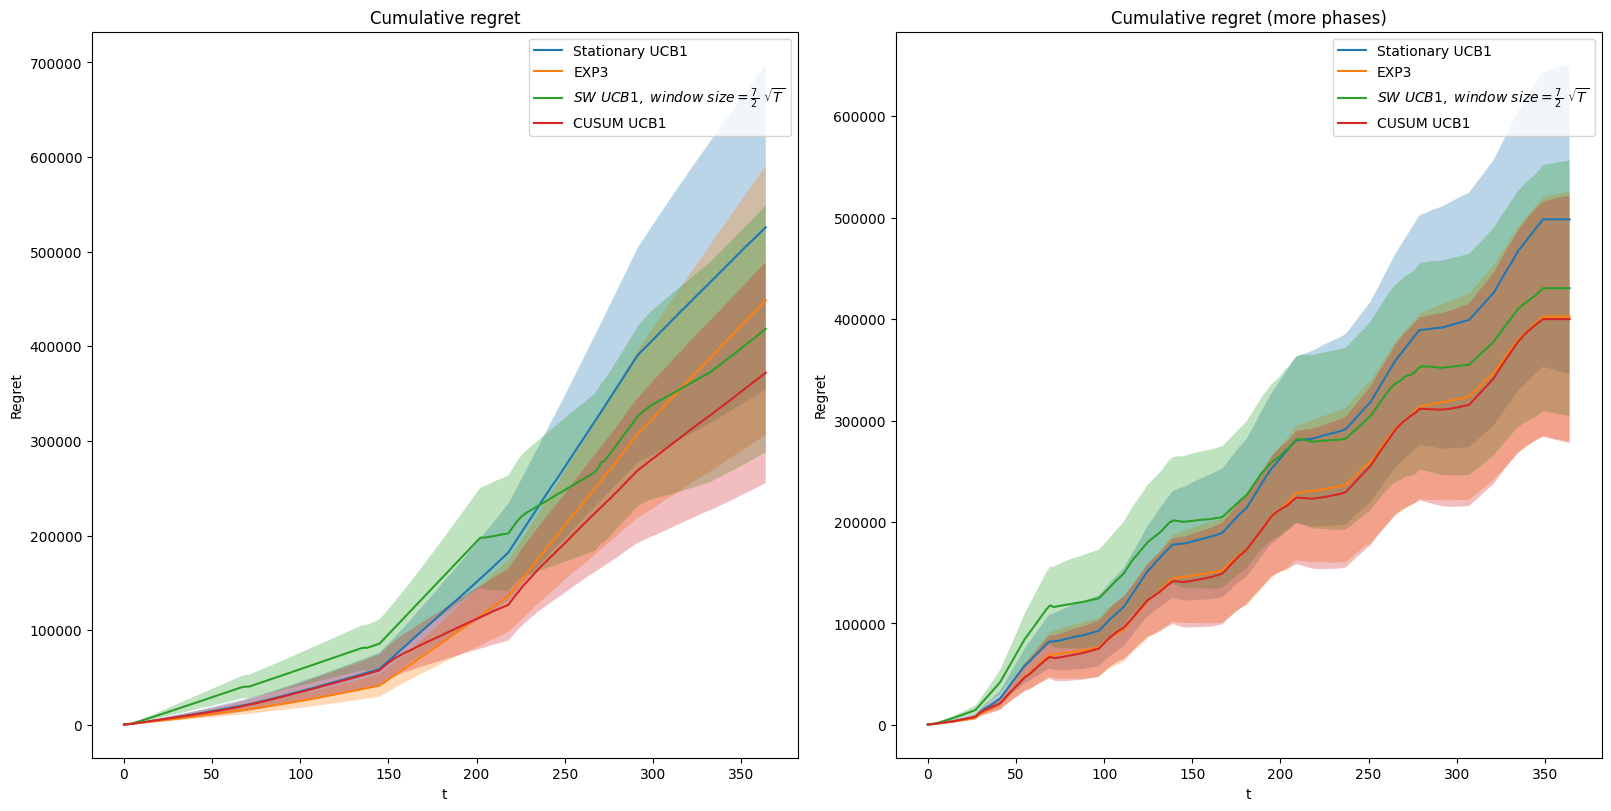

[[0.84 0.67 0.3  0.27 0.16]
 [0.8  0.68 0.26 0.66 0.35]
 [0.49 0.82 0.74 0.69 0.79]
 [0.33 0.35 0.7  0.17 0.32]
 [0.95 0.18 0.2  0.14 0.53]]


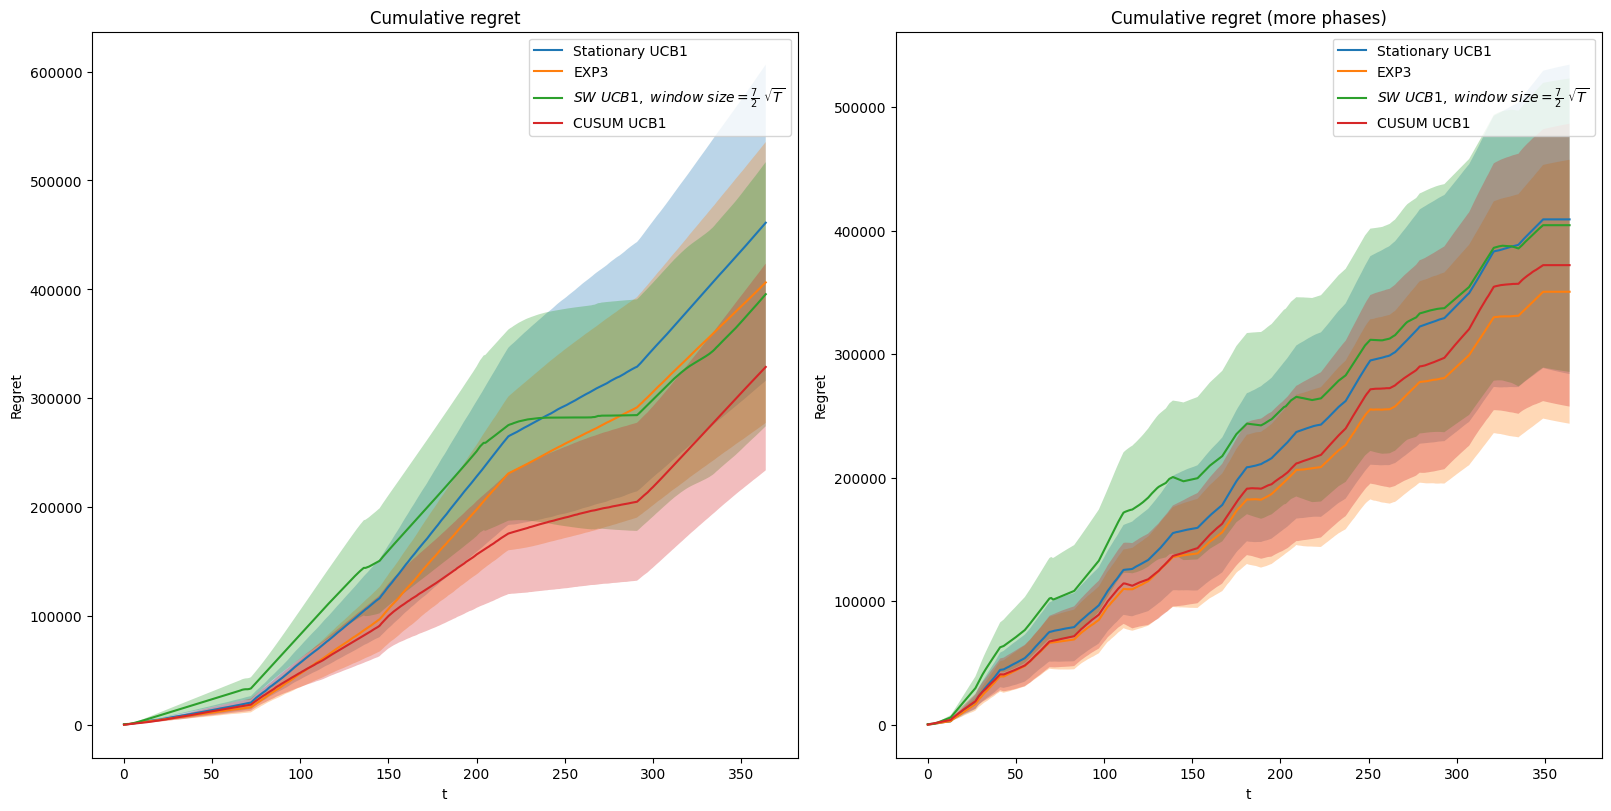

[[0.94 0.71 0.36 0.26 0.22]
 [0.99 0.48 0.75 0.86 0.36]
 [0.92 0.9  0.16 0.89 0.32]
 [0.2  0.52 0.49 0.41 0.82]
 [0.43 0.2  0.79 0.68 0.51]]


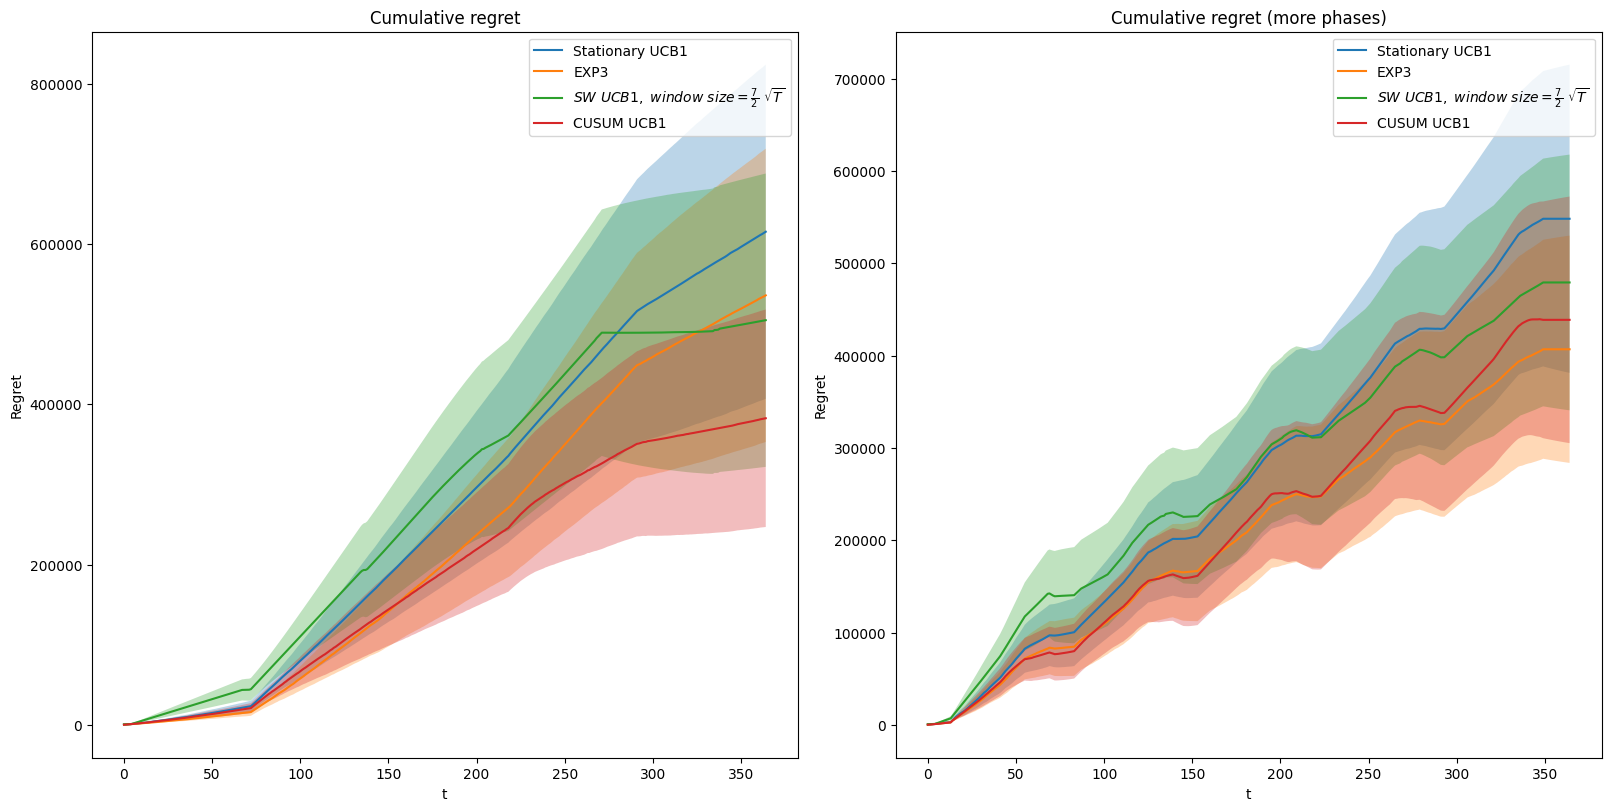

[[0.85 0.78 0.16 0.13 0.1 ]
 [0.97 0.87 0.22 0.36 0.77]
 [0.47 0.83 0.54 0.94 0.31]
 [0.46 0.61 0.4  0.1  0.19]
 [0.9  0.67 0.81 0.52 0.23]]


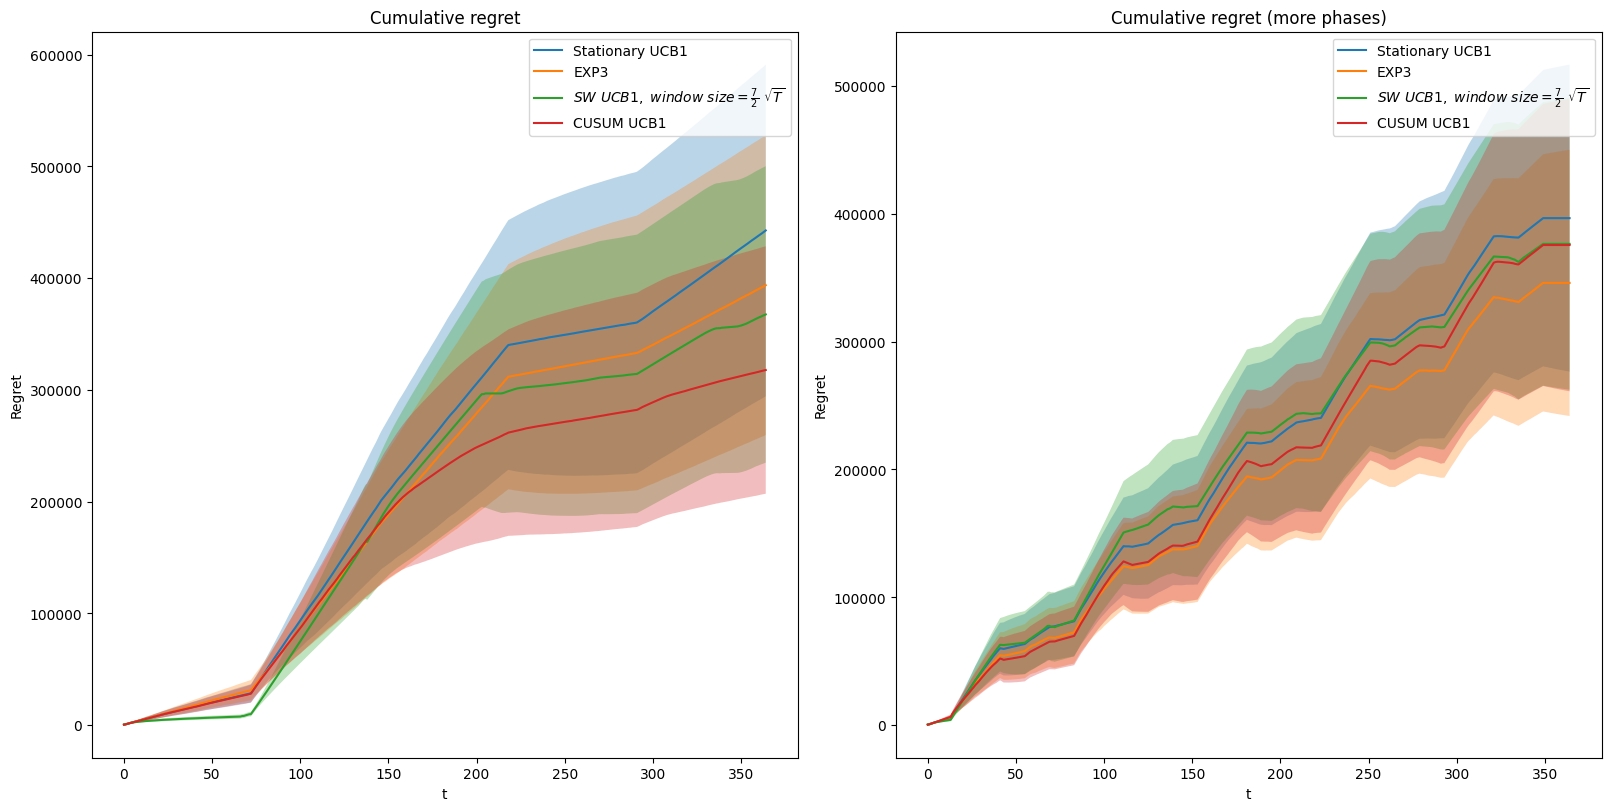

[[0.88 0.87 0.19 0.16 0.13]
 [0.81 0.95 0.41 0.8  0.86]
 [0.32 0.84 0.2  0.21 0.3 ]
 [0.41 0.72 0.1  0.51 0.7 ]
 [0.83 0.13 0.24 0.27 0.42]]


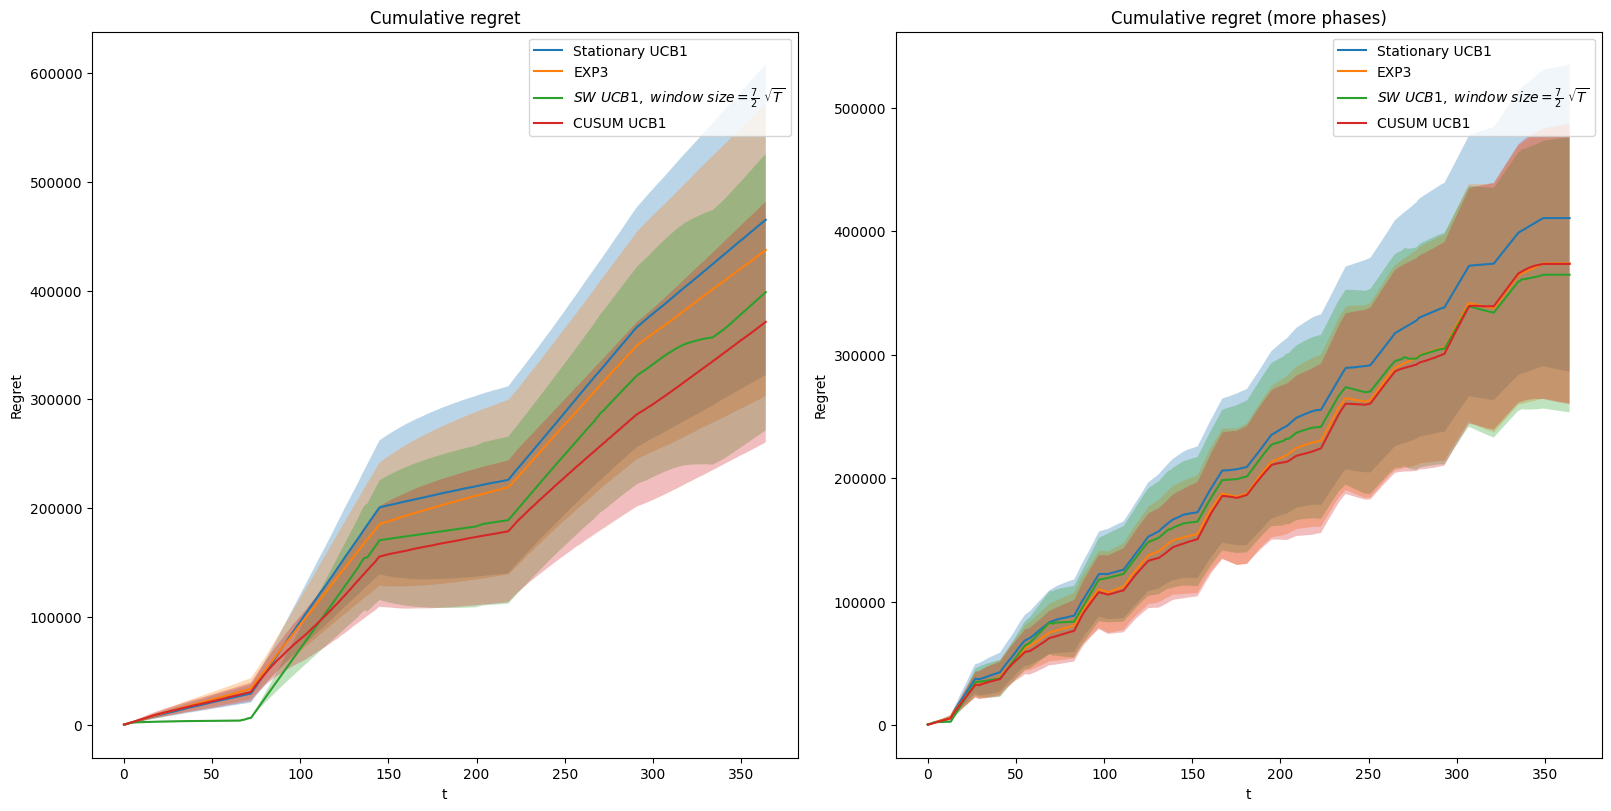

In [1]:
from Customer import *
from UCB1_Learner import *
from EXP3_Learner import *
from Non_Stationary_Environment import *
from SWUCB_Learner import *
from CDUCB_Learner import *
from plotResults import Plotter
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt
import json

with open('probabilities.json', 'r') as file:
    probabilities = json.load(file)

for prb in probabilities['prb_step6']:
    prb = np.array(prb)
    c1 = Customer('C1', -0.0081, 0.97, 32, 3.8, -1.5, 0.1, 100)
    prices = np.array([10, 20, 30, 40, 50])


    T = 365
    n_experiments = 50
    n_arms = len(prices)

    margin = (prices - 8)
    clicks = int(c1.num_clicks(2))
    cost = c1.click_cost(2)
    rewards = (margin * prb - cost) * clicks

    # UCB1, EXP3, SWUCB1, CUSUM
    n_alg = 4

    n_phases = 5
    phases_len = int(T / n_phases)

    # long: refers to setting with higher non-stationarity degree (more phases)
    n_phases_long = 25
    phases_len_long = int(T / n_phases_long)
    prb_long = np.tile(prb, reps=(5, 1))
    rewards_long = (margin * prb_long - cost) * clicks

    opt_per_phase = rewards.max(axis=1)
    opt_per_phase_long = rewards_long.max(axis=1)

    optimum_per_round = np.zeros(T)
    optimum_per_round_long = np.zeros(T)

    # window_size
    M = 10
    # exploration term
    eps = 0.15
    # detection threshold
    h = 3 * np.log(T)
    # scaling
    alpha = 0.1

    rewards_experiment = [[] for i in range(n_alg)]
    rewards_experiment_long = [[] for i in range(n_alg)]

    for e in range(0, n_experiments):
        env = [Non_Stationary_Environment(prb, T, n_phases) for i in range(n_alg)]
        env_long = [Non_Stationary_Environment(prb_long, T, n_phases_long)for i in range(n_alg)]

        learner = [
            UCB1_Learner(n_arms, prices, margin, clicks, cost),
            EXP3_Learner(n_arms, prices, margin, clicks, cost),
            SWUCB_Learner(n_arms, prices, int(7/2 * sqrt(T)), margin, clicks, cost),
            CDUCB_Learner(n_arms, prices, M, eps, h, alpha, margin, clicks, cost)
        ]
        learner_long = [
            UCB1_Learner(n_arms, prices, margin, clicks, cost),
            EXP3_Learner(n_arms, prices, margin, clicks, cost),
            SWUCB_Learner(n_arms, prices, int(7/2 * sqrt(T)), margin, clicks, cost),
            CDUCB_Learner(n_arms, prices, M, eps, h, alpha, margin, clicks, cost)
        ]

        for t in range(0, T):
            for i in range(n_alg):
                pulled_arm = learner[i].pull_arm()
                reward = env[i].round(pulled_arm, clicks)
                learner[i].update(pulled_arm, reward)

                pulled_arm = learner_long[i].pull_arm()
                reward = env_long[i].round(pulled_arm, clicks)
                learner_long[i].update(pulled_arm, reward)

        [rewards_experiment[i].append(learner[i].collected_rewards) for i in range(n_alg)]
        [rewards_experiment_long[i].append(learner_long[i].collected_rewards) for i in range(n_alg)]

    rewards_experiment = [np.array(rewards_experiment[i]) for i in range(n_alg)]
    rewards_experiment_long = [np.array(rewards_experiment_long[i]) for i in range(n_alg)]

    regret = [np.zeros(T) for _ in range(n_alg)]
    regret_long = [np.zeros(T) for _ in range(n_alg)]
    std_regret = [np.zeros(T) for _ in range(n_alg)]
    std_regret_long = [np.zeros(T) for _ in range(n_alg)]

    for i in range(n_phases):
        t_index = range(i * phases_len, (i + 1) * phases_len)
        optimum_per_round[t_index] = opt_per_phase[i]
        for alg in range(n_alg):
            # Regret
            regret[alg][t_index] = np.mean(opt_per_phase[i] - rewards_experiment[alg], axis=0)[t_index]
            # Standard deviation instantaneous regret
            std_regret[alg][t_index] = np.std(opt_per_phase[i] - rewards_experiment[alg], axis=0)[t_index]

    for i in range(n_phases_long):
        t_index = range(i * phases_len_long, (i + 1) * phases_len_long)
        optimum_per_round_long[t_index] = opt_per_phase_long[i]
        for alg in range(n_alg):
            # Regret
            regret_long[alg][t_index] = np.mean(opt_per_phase_long[i] - rewards_experiment_long[alg], axis=0)[t_index]
            # Standard deviation instantaneous regret
            std_regret_long[alg][t_index] = np.std(opt_per_phase_long[i] - rewards_experiment_long[alg], axis=0)[t_index]

    # Instantaneous reward
    inst_reward = [np.mean(rewards_experiment[i], axis=0) for i in range(n_alg)]
    inst_reward_long = [np.mean(rewards_experiment_long[i], axis=0) for i in range(n_alg)]
    # Cumulative regret
    cum_regret = [np.cumsum(regret[i]) for i in range(n_alg)]
    cum_regret_long = [np.cumsum(regret_long[i]) for i in range(n_alg)]
    # Cumulative reward
    cum_reward = [np.cumsum(np.mean(rewards_experiment[i], axis=0)) for i in range(n_alg)]
    cum_reward_long = [np.cumsum(np.mean(rewards_experiment_long[i], axis=0)) for i in range(n_alg)]
    # Standard deviation cumulative regret
    cumstd_regret = [[(np.cumsum(regret[alg]))[:i].std() for i in range(1, T + 1)] for alg in range(n_alg)]
    cumstd_regret_long = [[(np.cumsum(regret_long[alg]))[:i].std() for i in range(1, T + 1)] for alg in range(n_alg)]
    # Standard deviation instantaneous reward
    std_reward = [np.std(rewards_experiment[i], axis=0) for i in range(n_alg)]
    std_reward_long = [np.std(rewards_experiment_long[i], axis=0) for i in range(n_alg)]
    # Standard deviation cumulative reward
    cumstd_reward = [[(np.cumsum(rewards_experiment[alg]))[:i].std() for i in range(1, T + 1)] for alg in range(n_alg)]
    cumstd_reward_long = [[(np.cumsum(rewards_experiment_long[alg]))[:i].std() for i in range(1, T + 1)] for alg in range(n_alg)]

    # Plot results
    print(prb)
    dataset = np.array(
        [
                [[
                    [cum_regret[i], cumstd_regret[i]]
                ] for i in range(n_alg)],
                [[
                    [cum_regret_long[i], cumstd_regret_long[i]]
                ] for i in range(n_alg)]
                ])

    titles = ["Cumulative regret"]

    ucb1_label = "Stationary UCB1"
    exp3_label = "EXP3"
    swucb_label = r"$SW\ UCB1,\ window\ size=\frac{7}{2}\ \sqrt{T}$"
    cducb_label = "CUSUM UCB1"
    labels = [ucb1_label, exp3_label, swucb_label, cducb_label]

    plotter = Plotter(dataset, optimum_per_round, titles, labels, T)
    plotter.subplots()
